In [20]:
import math
import os
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from luis_data_prep.NoiseGate import NoiseGate


# Create dataset: read in audio samples
# For each audio sample, use a sliding window to extract features
# output: X of features, y of labels
DATA_DIR = '../data'
notHidden = lambda x: not x.startswith('.')
classes = [d for d in os.listdir(DATA_DIR) if notHidden(d)]

X = []
y = []

win_size = 1    # in seconds
for i, c in enumerate(classes):
    wavs = filter(notHidden, os.listdir(os.path.join(DATA_DIR, c)))
    for w in wavs:
        path = os.path.join(DATA_DIR, c, w)
        sample, sampling_rate = librosa.load(path)

        win_length = win_size * sampling_rate
        n_fft = 2 ** math.ceil(math.log(win_length, 2))
        sgram = librosa.stft(sample, n_fft=n_fft, win_length=win_length, hop_length=win_length//2)
        xs = np.transpose(np.abs(sgram[:sampling_rate//2, :]))
        ys = np.ones((xs.shape[0], 1)) * i

        X.append(xs)
        y.append(ys)

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

print(X.shape)
print(y.shape)

(1435, 11025)
(1435, 1)


/var/folders/6r/d2q58r491zv1x52wgf4ss1m40000gn/T/ipykernel_77049/4086539002.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(classes[int(y[i])])


Text(0.5, 1.0, 'Seiko^^^Model_5^^^Movement_4R36^^^21600^^^41hrs^^^SN00005')

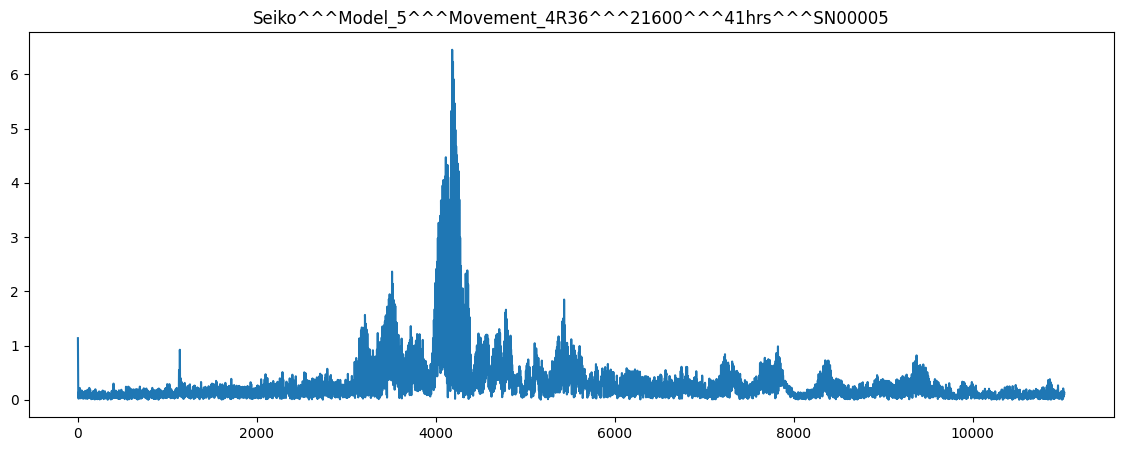

In [40]:
# View an arbitrary feature
i = 206
fig = plt.figure(figsize=(14,5))
plt.plot(X[i,:])
plt.title(classes[int(y[i])])

In [55]:
# Visualize multi-dimensional scaling of all the points without dimensionality reduction
from sklearn import manifold

def viewMds(X, y):
    embedding = manifold.MDS(
        n_components=2,
        max_iter=3000,          # about 2m30s
    )
    X_lowd = embedding.fit_transform(X)

    fig, ax = plt.subplots(figsize=(14, 14), facecolor="white", constrained_layout=True)
    Xx, Xy = X_lowd.T
    ax.scatter(Xx, Xy, c=y, alpha=0.8)


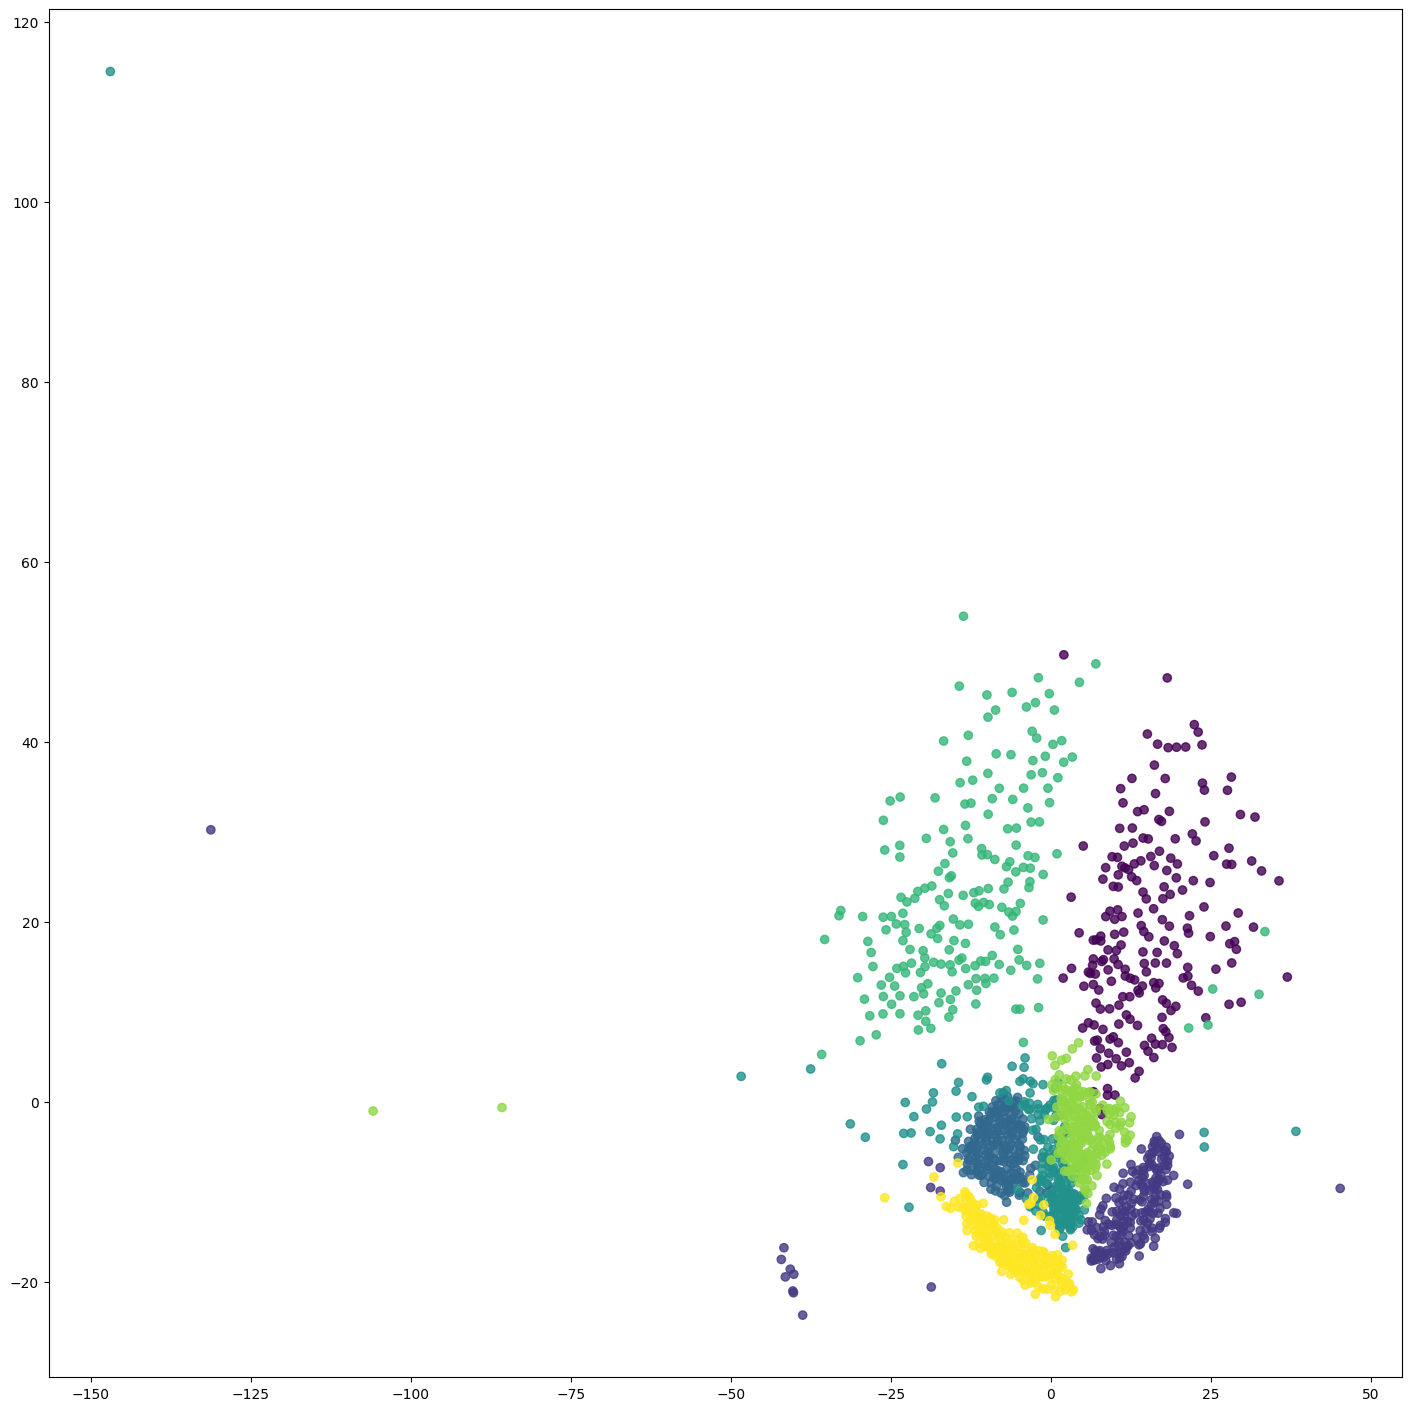

In [85]:
viewMds(X, y)

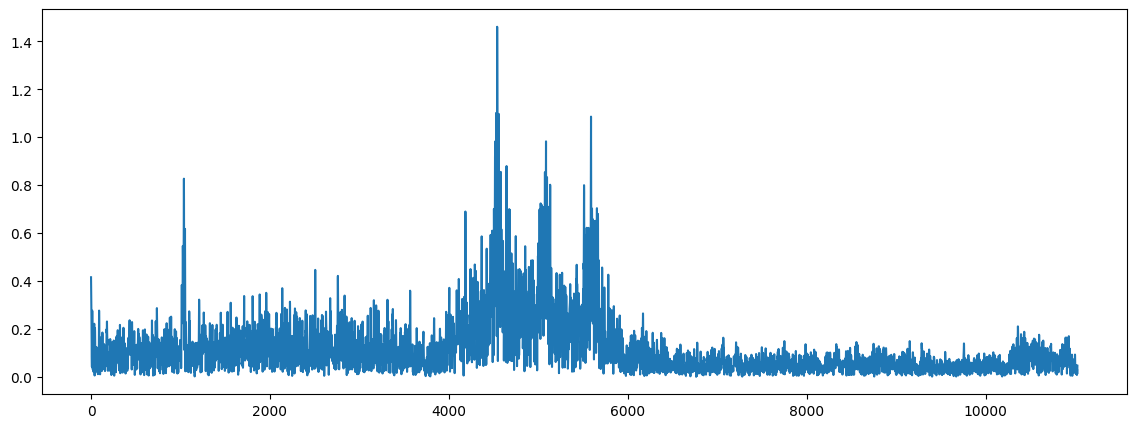

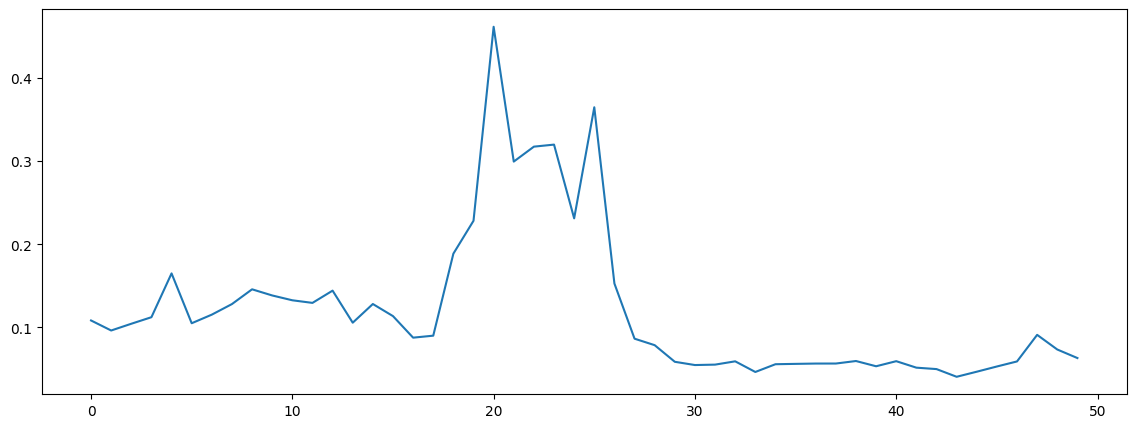

In [83]:
# Dimensionality reduction via increasing the coarsness of the histogram
from scipy.stats import binned_statistic

n_bins = 50

freqs = np.linspace(0, X.shape[1], X.shape[1])
bins = np.linspace(0, X.shape[1], n_bins + 1)
bin_assignment = np.digitize(freqs, bins)                # Assign each index in the FFT result a bin

X_coarse = np.zeros((X.shape[0], n_bins))
for i in range(X.shape[0]):
    X_coarse[i, :] = np.array([X[i, bin_assignment == j].mean() for j in  range(1, len(bins))])

# Sanity check
plt.figure(figsize=(14,5))
plt.plot(X[450, :])
plt.figure(figsize=(14,5))
plt.plot(X_coarse[450,:])

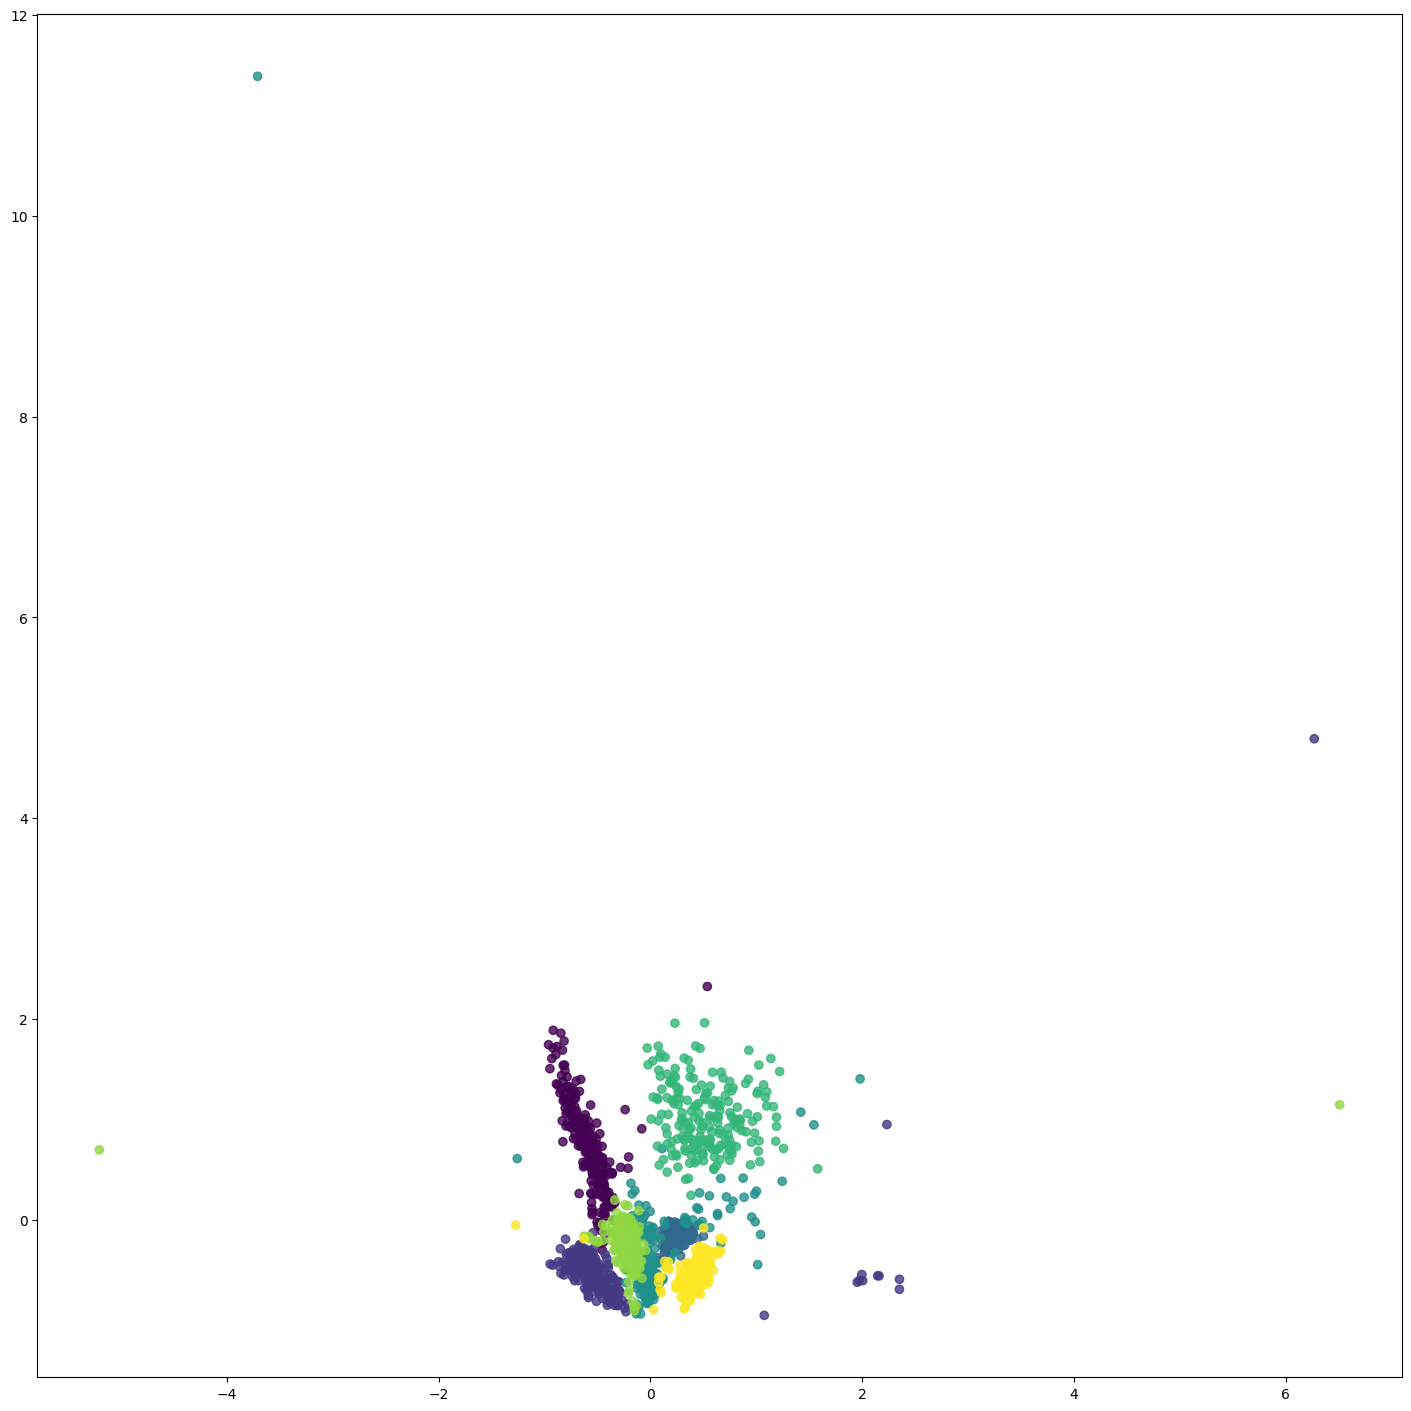

In [84]:
viewMds(X_coarse, y)

In [ ]:
# Fit GMM?
# Radial basis SVMs?
# Split data and calculate cross-validation scores